# Imports

In [1]:
import os
import pandas
from bumps.cli import load_model, load_best
from bumps.dream.state import load_state
from scattertools.support import molstat
import shutil

from IPython.core.magic import register_cell_magic
@register_cell_magic
def write_and_run(line, cell):
    argz = line.split()
    file = argz[-1]
    mode = 'w'
    if len(argz) == 2 and argz[0] == '-a':
        mode = 'a'
    with open(file, mode) as f:
        f.write(cell)
    get_ipython().run_cell(cell)

# Variables

Variables to set the storage folder for the fit, the base name of the runfile, and the global optimizer. Further the
number of burn and production stepst for the MCMC are set. The run flag determines whether the refl1d MCMC is run, or
just a data analysis on a previous fit is performed.

Steps (and burn) are intentionally small in this example to reduce file sizes.

In [2]:
setupdir = os.getcwd()
store = "fit"
runfile = "tblm_protein_hermite"
fitsource = "refl1d"

if not os.path.isdir(store):
    os.mkdir(store)

run = False
burn = 2000
steps = 200


# Example Fit

The content of the following cell is written out to the runfile of the fit 'tblm.py'.

In [3]:
%%write_and_run tblm_protein_hermite.py
# === Import section ===
import numpy
from molgroups import mol
from molgroups import components as cmp
from molgroups import lipids
from refl1d.names import load4, Parameter, SLD, Slab, Experiment, FitProblem
from refl1d.flayer import FunctionalProfile

# === Constant definition section ===
# Canvas
DIMENSION = 300
STEPSIZE = 0.5

# Hermite Spline
CONTROLPOINTS = 6
SPACING = 15.0
PENETRATION = 12
dDp = [None] * CONTROLPOINTS
dVf = [None] * CONTROLPOINTS

# SLDS
PROTDEUT = 1.67e-6
PROTNONDEUT = 3.14e-6
NSLDH2O = -0.5666e-6
NSLDD2O = 6.36e-6

# Define bilayer and protein objects
blm = mol.tBLM(tether=lipids.HC18SAc, filler=cmp.bmeSAc, lipids=[lipids.POPC], lipid_nf=[1.0])
protein = mol.Hermite()
protein.numberofcontrolpoints = CONTROLPOINTS
blm_prot = mol.BLMProteinComplex(blms=[blm], proteins=[protein])


# Bilayer profile definition function
def bilayer(z, sigma, bulknsld, global_rough, rho_substrate, nf_tether, mult_tether, l_tether, l_lipid1, l_lipid2,
            vf_bilayer):
    """ Generic tethered bilayer """

    # Scale all SLDs from Refl1D units (1e-6 Ang^-2) to molgroups units (Ang^-2)
    bulknsld = bulknsld * 1e-6
    rho_substrate = rho_substrate * 1e-6

    blm.fnSet(sigma=sigma, bulknsld=bulknsld, global_rough=global_rough, rho_substrate=rho_substrate,
              nf_tether=nf_tether, mult_tether=mult_tether, l_tether=l_tether, l_lipid1=l_lipid1, l_lipid2=l_lipid2,
              vf_bilayer=vf_bilayer)
    # Calculate scattering properties of volume occupied by bilayer
    maxarea, area, nsl = blm.fnWriteProfile(z)
    # normarea equals maxarea because of substrate layers, otherwise normarea = blm.normarea
    normarea = maxarea
    # Fill in the remaining volume with buffer of appropriate nSLD
    nsld = nsl / (normarea * numpy.gradient(z)) + (1.0 - area / normarea) * bulknsld

    # export objects for post analysis, needs to be from this function
    # problem.bilayers = [blm]
    # problem.dimension = DIMENSION
    # problem.stepsize = STEPSIZE
    # problem.moldat = blm.fnWriteGroup2Dict({}, 'bilayer', numpy.arange(DIMENSION) * STEPSIZE)

    # Return nSLD profile in Refl1D units
    return nsld * 1e6


def bilayer_prot(z, sigma, bulknsld, global_rough, rho_substrate, nf_tether, mult_tether, l_tether, l_lipid1,
                    l_lipid2, vf_bilayer, nf_protein, protexchratio, dDp, dVf):
    """ Generic tethered bilayer """

    # Scale all SLDs from Refl1D units (1e-6 Ang^-2) to molgroups units (Ang^-2)
    bulknsld = bulknsld * 1e-6
    rho_substrate = rho_substrate * 1e-6

    # Calculate scattering properties of volume occupied by bilayer
    protSLD = PROTNONDEUT + protexchratio * (bulknsld-NSLDH2O) / (NSLDD2O-NSLDH2O) * (PROTDEUT-PROTNONDEUT)
    blm_prot.proteins[0].fnSetRelative(SPACING, blm.headgroups2[0].fnGetZ() + 0.5 * 9.56 - PENETRATION, dDp, dVf, protSLD, nf_protein)
    blm_prot.blms[0].fnSet(sigma=sigma, bulknsld=bulknsld, global_rough=global_rough, rho_substrate=rho_substrate,
              nf_tether=nf_tether, mult_tether=mult_tether, l_tether=l_tether, l_lipid1=l_lipid1, l_lipid2=l_lipid2,
              vf_bilayer=vf_bilayer)
    blm_prot.fnAdjustBLMs()
    maxarea, area, nsl = blm_prot.fnWriteProfile(z)
    # normarea equals maxarea because of substrate layers, otherwise normarea = blm_prot.blms[0].normarea, for example
    normarea = maxarea
    # Fill in the remaining volume with buffer of appropriate nSLD
    nsld = nsl / (normarea * numpy.gradient(z)) + (1.0 - area / normarea) * bulknsld

    # export objects for post analysis, needs to be in this function
    # for statistical analysis of molgroups
    moldict1 = blm_prot.blms[0].fnWriteGroup2Dict({}, 'bilayer', numpy.arange(DIMENSION) * STEPSIZE)
    moldict2 = blm_prot.proteins[0].fnWriteGroup2Dict({}, 'protein', numpy.arange(DIMENSION) * STEPSIZE)
    problem.moldat = {**moldict1, **moldict2}
    dict3 = blm_prot.blms[0].fnWriteResults2Dict({}, 'substrate')
    dict4 = blm_prot.proteins[0].fnWriteResults2Dict({}, 'protein')
    problem.results = {**dict3, **dict4}

    # Return nSLD profile in Refl1D units
    return nsld * 1e6


# bilayer parameters
vf_bilayer = Parameter(name='vf_bilayer', value=0.9).range(0.0, 1.0)                #volume fraction bilayer
l_lipid1 = Parameter(name='l_lipid1', value=10.0).range(8, 30)                      #inner methylenes
l_lipid2 = Parameter(name='l_lipid2', value=10.0).range(8, 16)                      #outer methylenes
sigma = Parameter(name='sigma_blm', value=5).range(2, 8)                            #bilayer roughness
global_rough = Parameter(name='sigma_substrate', value=5).range(2, 9)               #substrate roughness
d_oxide = Parameter(name='d_oxide', value=10).range(5, 40)                          #silicon oxide thickness
d_Cr = Parameter(name='d_cr', value=40).range(10, 60)                              #chromium thickness
d_gold = Parameter(name='d_gold', value=100).range(130, 150)                        #gold thickness
rough_cr_au = Parameter(name='sigma_cr_au', value=10).range(1, 15.0)                #chromium-gold interface roughness
nf_tether = Parameter(name='nf_tether', value=0.7).range(0.2, 1.0)                  #number fraction tether
mult_tether = Parameter(name='mult_tether', value=2).range(0.1, 4)                  #bme-to-tether ratio
l_tether = Parameter(name='l_tether', value=10).range(3, 18)

# protein parameters
dl_lipid = Parameter(name='dl_lipid', value=0.0).range(-3., 3.0)                    #change in methylene thickness
vf_bilayer_prot = Parameter(name='vf_bilayer_prot', value=0.9).range(0.0, 1.0)      #volume fraction bilayer w/ protein
nf_protein = 1
protexchratio = 0.8
for i in range(len(dDp)):
    dDp[i] = Parameter(name='dDp'+str(i), value=0.0).range(-1 * SPACING / 3., SPACING / 3.)
for i in range(1, len(dVf)-1):
    dVf[i] = Parameter(name='dVf'+str(i), value=0.001).range(-0.001, 0.4)
# first and last controlpoint is at zero volume fraction
dVf[0] = dVf[-1] = 0.0

# === Stack ===
# First, we create a 'material' for each bulk layer, which has an real and imaginary
# scattering length density, stored in a Refl1d object called 'SLD'
d2o = SLD(name='d2o', rho=6.3000, irho=0.0000)
h2o = SLD(name='h2o', rho=-0.56, irho=0.0000)
d2o_prot = SLD(name='d2o_prot', rho=6.3000, irho=0.0000)
h2o_prot = SLD(name='h2o_prot', rho=-0.56, irho=0.0000)
siox = SLD(name='siox', rho=4.1000, irho=0.0000)
silicon = SLD(name='silicon', rho=2.0690, irho=0.0000)
cr = SLD(name='chromium', rho=2.7, irho=0.0)
gold = SLD(name='gold', rho=4.4, irho=0.0)

# Then bulk layers are created, each with its own 'material'.  If you want to force
# two layers to always match SLD you can use the same material in multiple layers.
# The roughnesses of each layer are set to zero to begin with:

layer_d2o = Slab(material=d2o, thickness=0.0000, interface=5.0000)
layer_h2o = Slab(material=h2o, thickness=0.0000, interface=5.0000)
layer_d2o_prot = Slab(material=d2o_prot, thickness=0.0000, interface=5.0000)
layer_h2o_prot = Slab(material=h2o_prot, thickness=0.0000, interface=5.0000)
layer_siox = Slab(material=siox, thickness=d_oxide, interface=global_rough)
layer_silicon = Slab(material=silicon, thickness=0.0000, interface=global_rough)
layer_cr = Slab(material=cr, thickness=d_Cr, interface=rough_cr_au)
layer_gold = Slab(material=gold, thickness=d_gold - (blm.substrate.z + 0.5 * blm.substrate.length), interface=0.0000)

# Use the bilayer definition function to generate the bilayer SLD profile, passing in the relevant parameters.
# Note that substrate and bulk SLDs are linked to their respective materials.
mollayer = FunctionalProfile(DIMENSION * STEPSIZE, 0, profile=bilayer, sigma=sigma, bulknsld=d2o.rho,
                             global_rough=global_rough, rho_substrate=gold.rho, nf_tether=nf_tether,
                             mult_tether=mult_tether, l_tether=l_tether, l_lipid1=l_lipid1, l_lipid2=l_lipid2,
                             vf_bilayer=vf_bilayer)

mollayerh = FunctionalProfile(DIMENSION * STEPSIZE, 0, profile=bilayer, sigma=sigma, bulknsld=h2o.rho,
                              global_rough=global_rough, rho_substrate=gold.rho, nf_tether=nf_tether,
                              mult_tether=mult_tether, l_tether=l_tether, l_lipid1=l_lipid1, l_lipid2=l_lipid2,
                              vf_bilayer=vf_bilayer)
mollayer_prot = FunctionalProfile(DIMENSION * STEPSIZE, 0, profile=bilayer_prot, sigma=sigma, bulknsld=d2o_prot.rho,
                                  global_rough=global_rough, rho_substrate=gold.rho, nf_tether=nf_tether,
                                  mult_tether=mult_tether, l_tether=l_tether, l_lipid1=l_lipid1+dl_lipid,
                                  l_lipid2=l_lipid2+dl_lipid, vf_bilayer=vf_bilayer_prot, nf_protein=nf_protein,
                                  protexchratio=protexchratio, dDp=dDp, dVf=dVf)

mollayerh_prot = FunctionalProfile(DIMENSION * STEPSIZE, 0, profile=bilayer_prot, sigma=sigma, bulknsld=h2o_prot.rho,
                                   global_rough=global_rough, rho_substrate=gold.rho, nf_tether=nf_tether,
                                   mult_tether=mult_tether, l_tether=l_tether, l_lipid1=l_lipid1+dl_lipid,
                                   l_lipid2=l_lipid2+dl_lipid, vf_bilayer=vf_bilayer_prot, nf_protein=nf_protein,
                                   protexchratio=protexchratio, dDp=dDp, dVf=dVf)

# Stack the layers into individual samples, using common layer objects for layers that are unchanged between samples
# Always build the sample from the substrate up. If the neutron beam is incident from the substrate side,
# set back_reflectivity = True in the probe definition later.

sample = layer_silicon | layer_siox | layer_cr | layer_gold | mollayer | layer_d2o
sampleh = layer_silicon | layer_siox | layer_cr | layer_gold | mollayerh | layer_h2o
sample_prot = layer_silicon | layer_siox | layer_cr | layer_gold | mollayer_prot | layer_d2o_prot
sampleh_prot = layer_silicon | layer_siox | layer_cr | layer_gold | mollayerh_prot | layer_h2o_prot

# Set sample parameter ranges and constraints between layer properties, if these are not set using parameters previously

# nSLD parameters
d2o.rho.range(5.8000, 6.4000)
h2o.rho.range(-0.6, 0.6)
d2o_prot.rho.range(5.8000, 6.4000)
h2o_prot.rho.range(-0.6, 0.6)
siox.rho.range(2.7000, 3.80)
cr.rho.range(2.7000, 4.15)
gold.rho.range(4.2000, 4.60)

# === Data files ===
probe = load4('kr095_4column.refl', back_reflectivity=True)
probeh = load4('kr096_4column.refl', back_reflectivity=True)
probe_prot = load4('kr097_4column.refl', back_reflectivity=True)
probeh_prot = load4('kr098_4column.refl', back_reflectivity=True)

# Background parameter
# probe.background.value = 0.0000
probe.background.range(-1e-9, 1e-5)
probeh.background.range(-1e-9, 1e-5)
probe_prot.background.range(-1e-9, 1e-5)
probeh_prot.background.range(-1e-9, 1e-5)
probe.intensity.range(0.95, 1.05)
probeh.intensity = probe.intensity
probe_prot.intensity = probe.intensity
probeh_prot.intensity = probe.intensity
probe.theta_offset.range(-0.001, 0.001)
probeh.theta_offset = probe.theta_offset
probe_prot.theta_offset = probe.theta_offset
probeh_prot.theta_offset = probe.theta_offset
probe.sample_broadening.range(-0.005, 0.02)
probeh.sample_broadening = probe.sample_broadening
probe_prot.sample_broadening = probe.sample_broadening
probeh_prot.sample_broadening = probe.sample_broadening

# Define critical edge oversampling for samples that require it (typically D2O only)
# probe.critical_edge(substrate=silicon, surface=d2o)

# === Problem definition ===
# a model object consists of a sample and a probe,

# step = True corresponds to a calculation of the reflectivity from an actual profile
# with microslabbed interfaces.  When step = False, the Nevot-Croce
# approximation is used to account for roughness.  This approximation speeds up
# the calculation tremendously, and is reasonably accuarate as long as the
# roughness is much less than the layer thickness
step = False

model = Experiment(sample=sample, probe=probe, dz=STEPSIZE, step_interfaces=step)
modelh = Experiment(sample=sampleh, probe=probeh, dz=STEPSIZE, step_interfaces=step)
model_prot = Experiment(sample=sample_prot, probe=probe_prot, dz=STEPSIZE, step_interfaces=step)
modelh_prot = Experiment(sample=sampleh_prot, probe=probeh_prot, dz=STEPSIZE, step_interfaces=step)
problem = FitProblem([model, modelh, model_prot, modelh_prot])

# Running the fit

The following runs the fit using rs.py. It can also be run manually from the command line using, for example:
> refl1d_cli.py tblm.py --fit=dream --init=lhs --parallel --store=fit --burn=16000 --steps=500

In [4]:
if run:
    if os.path.isdir(store):
        shutil.rmtree(store)
    os.mkdir(store)

fit_object = molstat.CMolStat(
    fitsource=fitsource,
    spath=setupdir,
    mcmcpath=store,
    runfile=runfile,
    state=None,
    problem=None
)

if run:
    # run fit
    fit_object.fnRunFit(burn=burn, steps=steps, batch=False)

print('Restore fit from: ', os.path.join(os.getcwd(), store, runfile))
fit_object.fnRestoreFit()

Restore fit from:  /Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/data_fitting/refl1d/tBLM_protein_hermite/fit/tblm_protein_hermite


# Analysis

Statistical analysis of fit results.

Median values, 68% confidence limits (-1, 94%: -2, etc.), and fit intervals for all fit parameters.

In [5]:
sparse = 0.001
fit_object.fnAnalyzeStatFile(fConfidence=-1, sparse=sparse)

No StatDataPython.dat.
Recreate statistical data from sErr.dat.
Found sErr.dat

Analysis of MCMC fit ...
Number of iterations: 69

Fit Parameters:


,origin,name,vis,lower limit,upper limit,lower percentile,median percentile,upper percentile,interval lower,interval upper,confidence
0,fit,background_kr095_4column,[+ ],-1.000000e-09,0.00001,2.511739e-07,3.359674e-07,3.997465e-07,-8.479348e-08,6.377913e-08,0.682689
1,fit,intensity_kr095_4column,[ | -| ],9.500000e-01,1.05000,9.825916e-01,9.978089e-01,1.014160e+00,-1.521735e-02,1.635121e-02,0.682689
2,fit,sample_broadening_kr095_4column,[ |-| ],-5.000000e-03,0.02000,-3.224935e-03,-9.334866e-04,1.917266e-03,-2.291449e-03,2.850752e-03,0.682689
3,fit,theta_offset_kr095_4column,[ | - | ],-1.000000e-03,0.00100,-7.763443e-04,-7.791107e-05,6.991626e-04,-6.984333e-04,7.770736e-04,0.682689
4,fit,sigma_substrate,[ |-| ],2.000000e+00,9.00000,5.188922e+00,5.924595e+00,6.608301e+00,-7.356731e-01,6.837056e-01,0.682689
...,...,...,...,...,...,...,...,...,...,...,...
84,substrate,water in submembrane,,NaN,NaN,-1.614204e-01,-8.144491e-02,-2.151150e-02,-7.997551e-02,5.993341e-02,0.682689
85,protein,peak position,,NaN,NaN,9.200000e+01,9.400000e+01,9.700000e+01,-2.000000e+00,3.000000e+00,0.682689
86,protein,FWHM,,NaN,NaN,1.544066e+01,1.909864e+01,3.097081e+01,-3.657975e+00,1.187217e+01,0.682689
87,protein,COM,,NaN,NaN,8.818638e+01,9.180445e+01,9.380138e+01,-3.618076e+00,1.996930e+00,0.682689


Create bilayer statistics from above parameter statistics. Results are saved to bilayerplotdata.dat.

In [6]:
fit_object.fnProfilesStat()

Plot selected data from bilayerplotdata.dat

In [7]:
pandas.DataFrame(fit_object.diStatResults['Molgroups'].keys(), columns=['molecular groups'])

,molecular groups
0,bilayer.bME
1,bilayer.defect_hg
2,bilayer.defect_hc
3,bilayer.headgroup1_1
4,bilayer.headgroup1_1.carbonyl_glycerol
5,bilayer.headgroup1_1.choline
6,bilayer.headgroup1_1.phosphate
7,bilayer.headgroup2_1
8,bilayer.headgroup2_1.carbonyl_glycerol
9,bilayer.headgroup2_1.choline


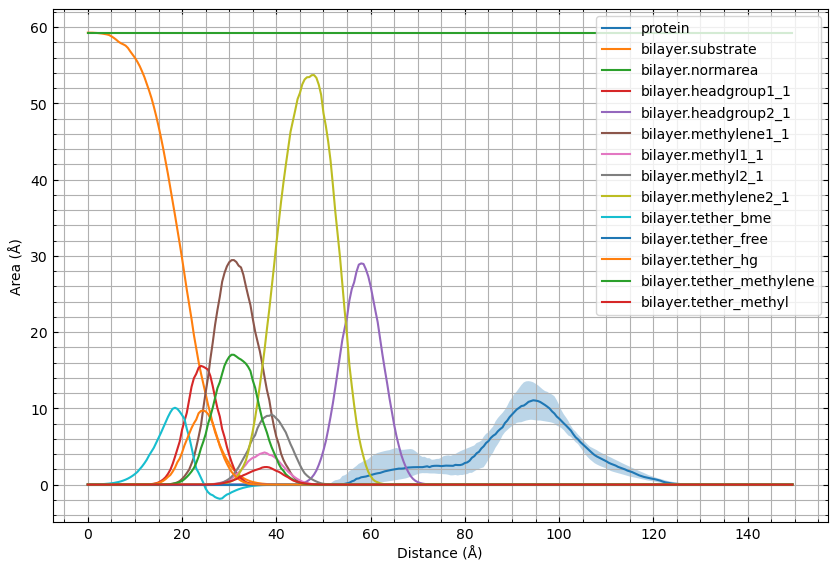

In [8]:
import matplotlib.pyplot as plt

median=['protein', 'bilayer.substrate', 'bilayer.normarea', 'bilayer.headgroup1_1', 'bilayer.headgroup2_1', 'bilayer.methylene1_1', 'bilayer.methyl1_1', 'bilayer.methyl2_1', 'bilayer.methylene2_1', 'bilayer.tether_bme', 'bilayer.tether_free', 'bilayer.tether_hg', 'bilayer.tether_methylene', 'bilayer.tether_methyl']
uncertainties=['protein']

fig, ax = plt.subplots()
for gp in median:
    zaxis = fit_object.diStatResults['Molgroups'][gp]['zaxis']
    area = fit_object.diStatResults['Molgroups'][gp]['median area']
    ax.plot(zaxis, area, label=gp)
    if gp in uncertainties:
        msigma = fit_object.diStatResults['Molgroups'][gp]['msigma area']
        psigma = fit_object.diStatResults['Molgroups'][gp]['psigma area']
        ax.fill_between(zaxis, msigma, psigma, alpha=0.3)

ax.legend(loc="upper right")
plt.xlabel("Distance (Å)")
plt.ylabel("Area (Å)")
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
#plt.xlim(0, 100)
#plt.xticks(numpy.arange(-35, 36, 5.0))
plt.grid(True, which='Both')
fig.patch.set_facecolor('white')
ax.figure.set_size_inches(10, 6.66)
plt.savefig(store + "/cvo", facecolor="white")
plt.show()

Compute statistical properties of interest with 68% confidence limits, such as the area per lipid of the outer lipid
leaflet.

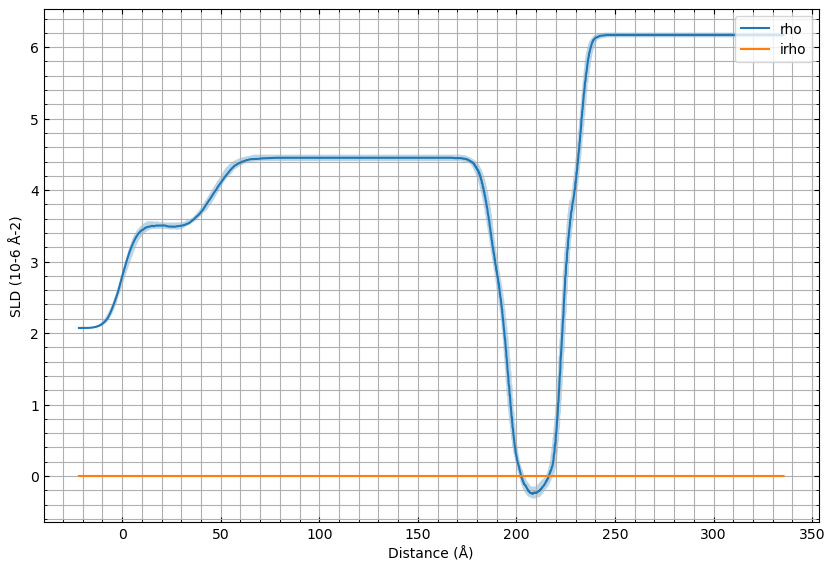

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
zaxis = fit_object.diStatResults['SLD']['z']

median = fit_object.diStatResults['SLD']['median rho']
ax.plot(zaxis, median, label='rho')
msigma = fit_object.diStatResults['SLD']['msigma rho']
psigma = fit_object.diStatResults['SLD']['psigma rho']
ax.fill_between(zaxis, msigma, psigma, alpha=0.3)

median = fit_object.diStatResults['SLD']['median irho']
ax.plot(zaxis, median, label='irho')
msigma = fit_object.diStatResults['SLD']['msigma irho']
psigma = fit_object.diStatResults['SLD']['psigma irho']
ax.fill_between(zaxis, msigma, psigma, alpha=0.3)

ax.legend(loc="upper right")
plt.xlabel("Distance (Å)")
plt.ylabel("SLD (10-6 Å-2)")
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
#plt.xlim(0, 100)
#plt.xticks(numpy.arange(-35, 36, 5.0))
plt.grid(True, which='Both')
fig.patch.set_facecolor('white')
ax.figure.set_size_inches(10, 6.66)
plt.savefig(store + "/sld", facecolor="white")
plt.show()

A simple way to show output files from the fit. Publication-ready graphs can be created from the data in the storage
directory or using fit_object:

# Publication-ready graphs

...

# Useful Routines


In [10]:
model = load_model(runfile+'.py')
load_best(model, os.path.join(store, runfile)+'.par')
model.chisq_str()

'1.017(99)'

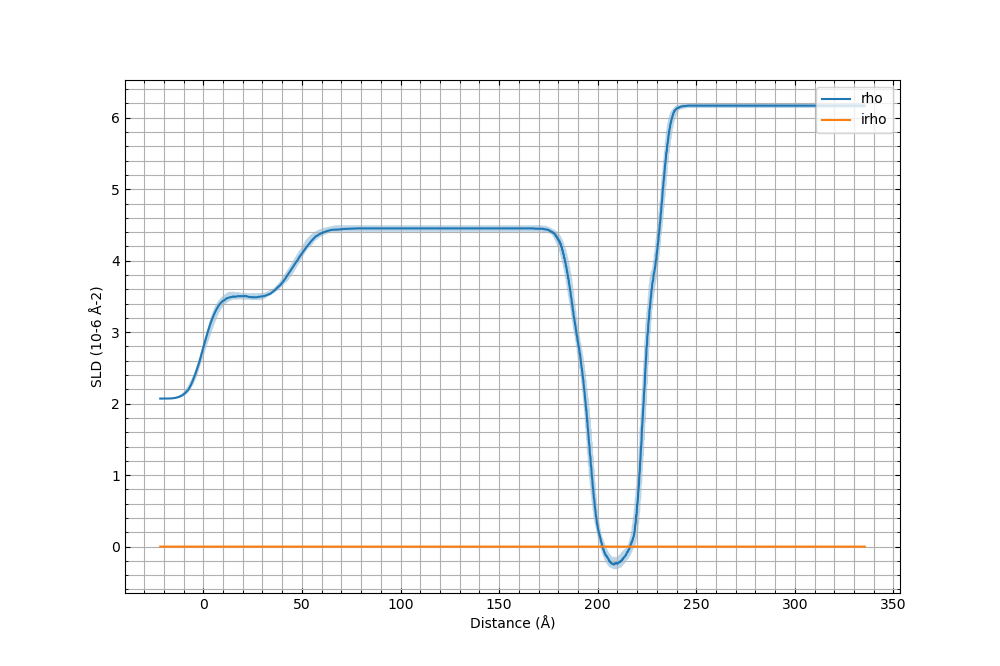

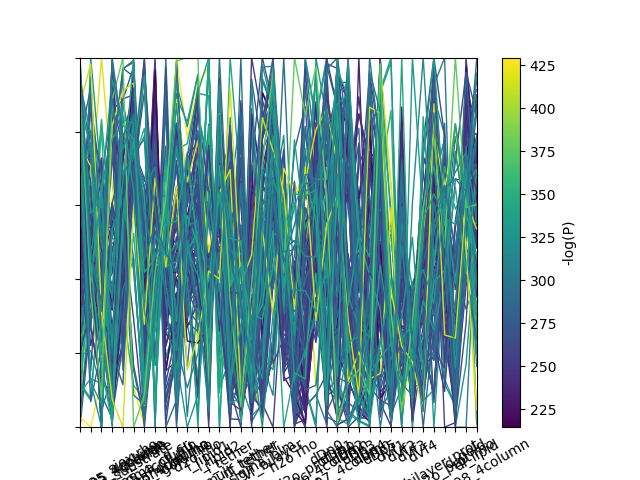

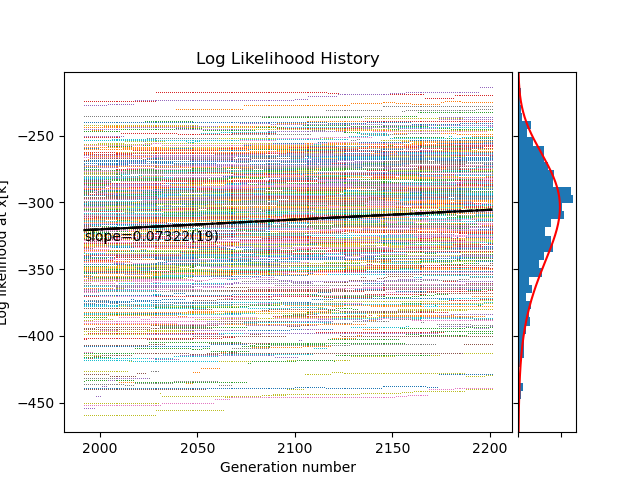

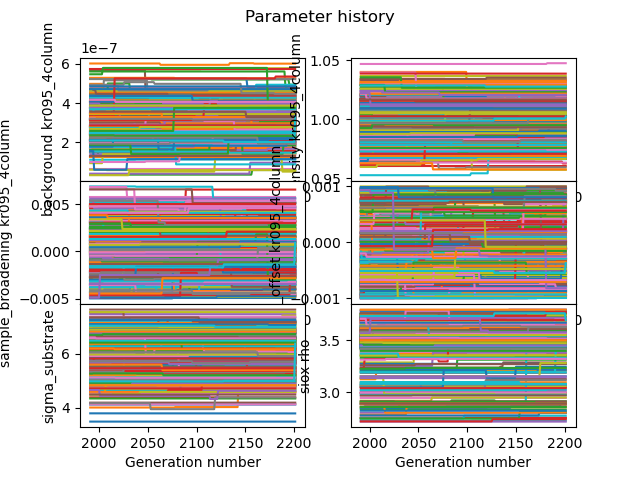

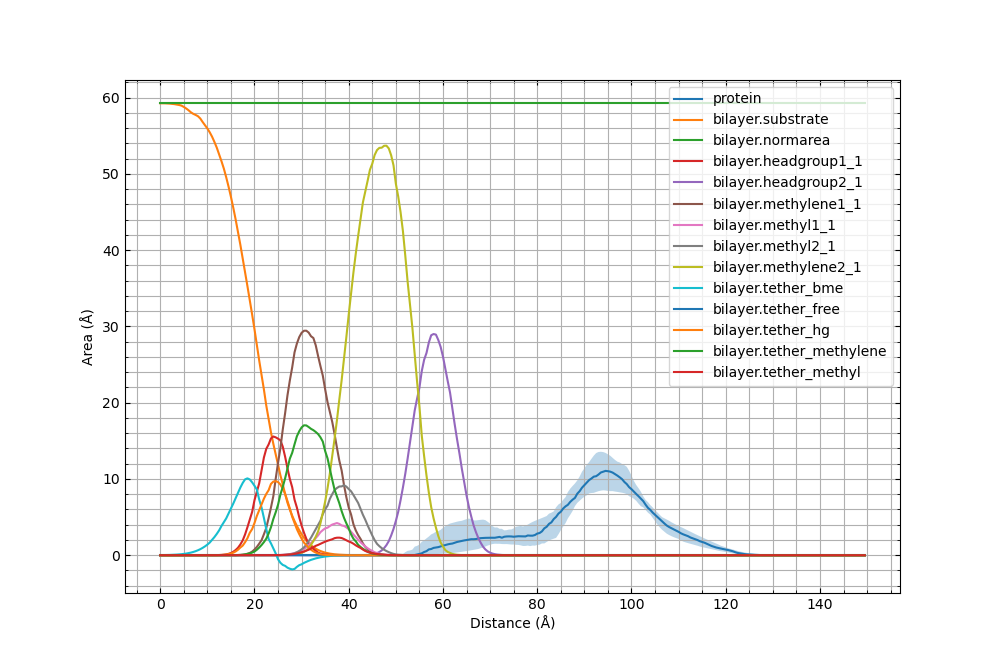

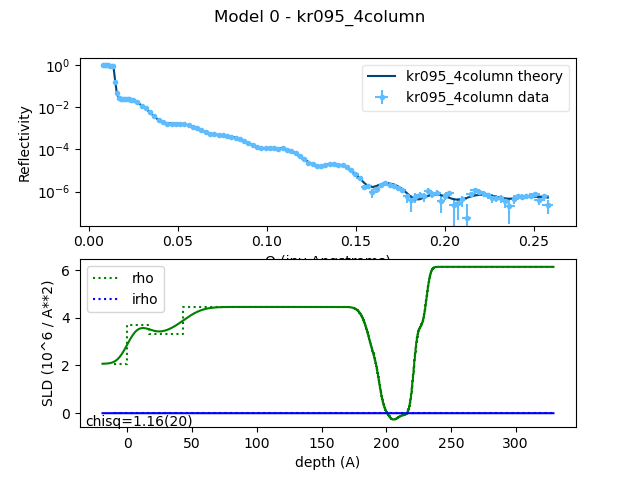

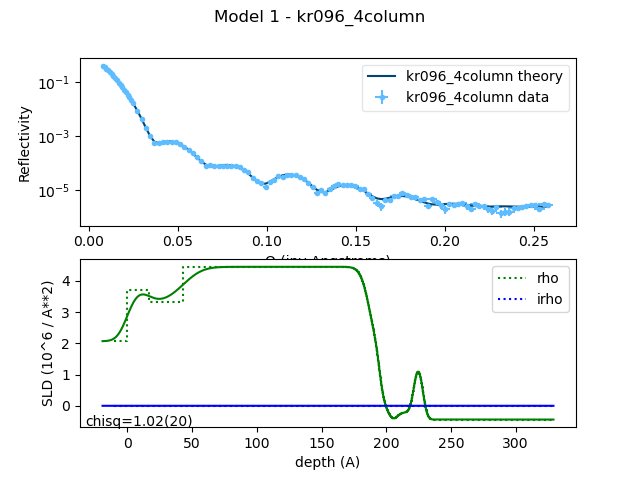

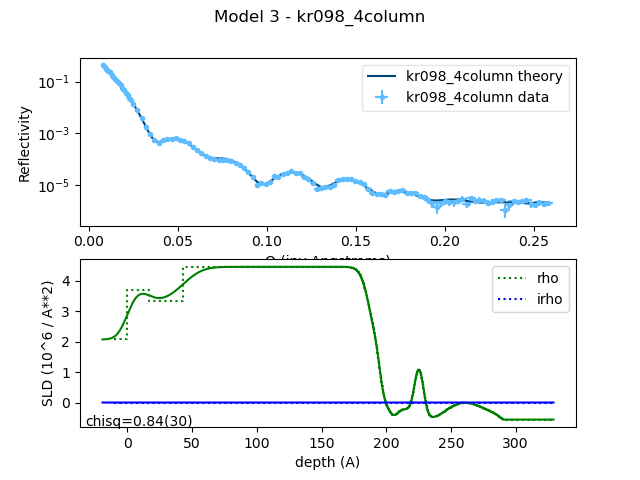

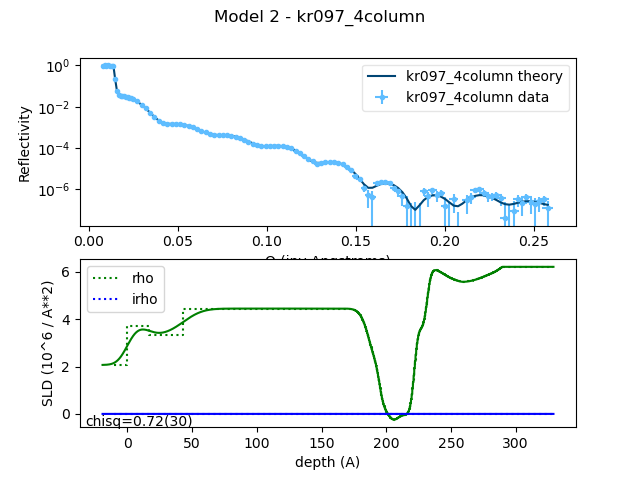

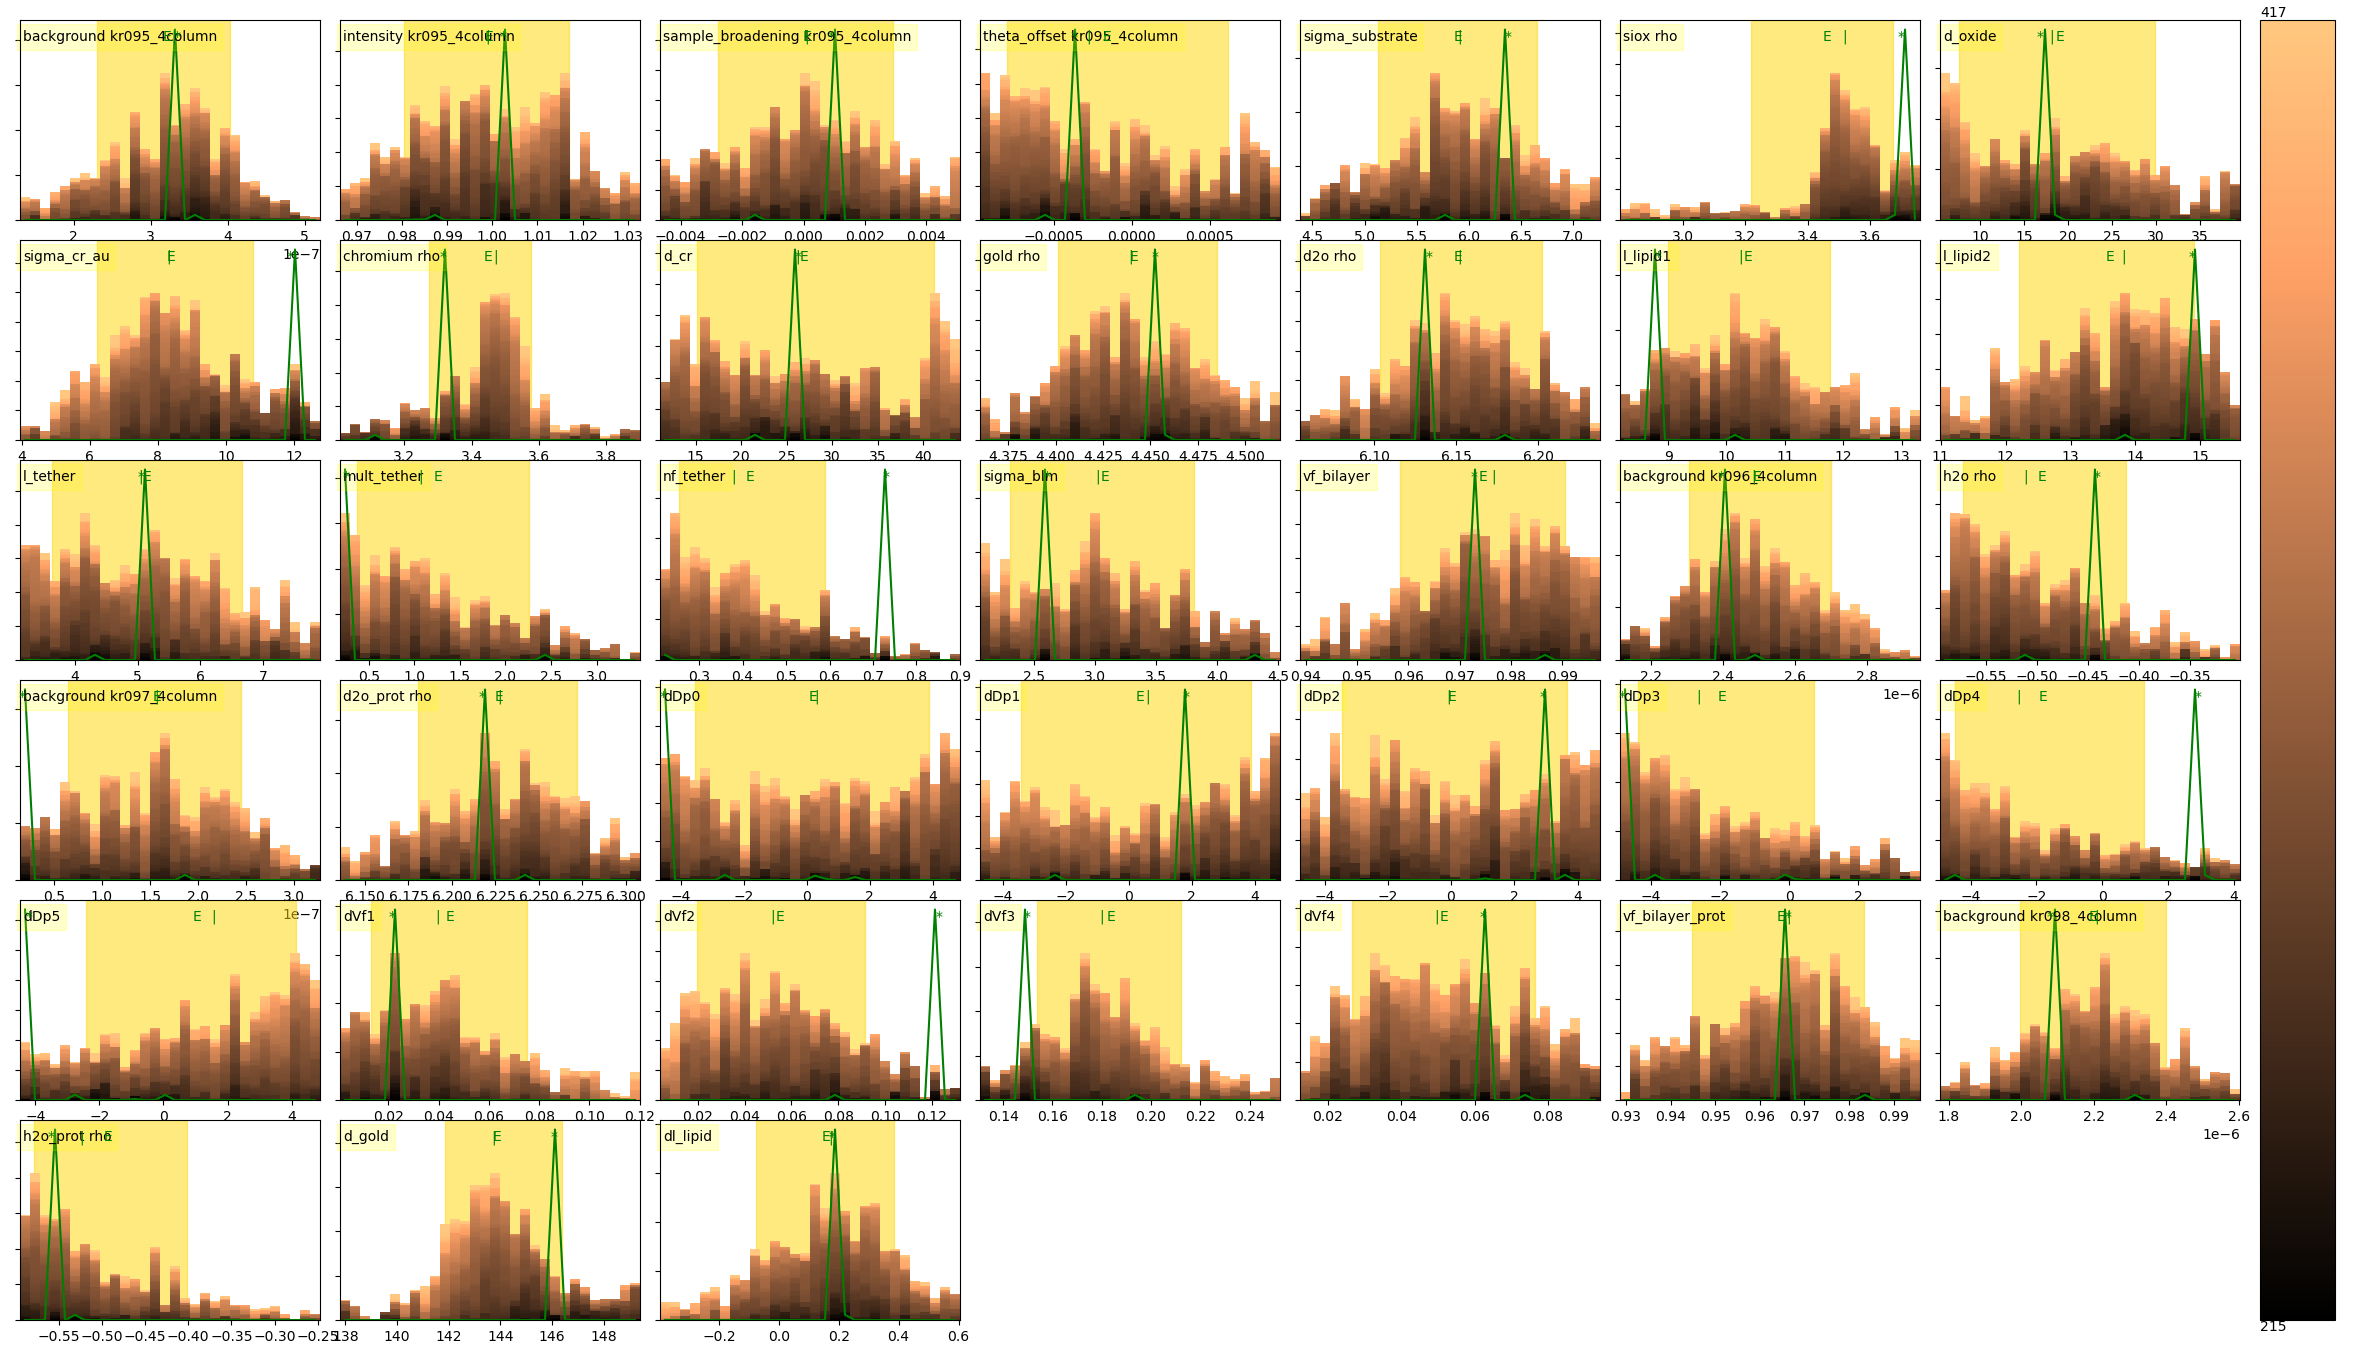

In [11]:
from IPython.display import Image, display
import glob
for file in glob.glob(os.path.join(store, "*.png")):
    display(Image(filename=file))